In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

# Create a list with the filepaths for training and testing
train_dir = Path('drive/MyDrive/AIR Project/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('drive/MyDrive/AIR Project/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('drive/MyDrive/AIR Project/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [ ]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 3183

Number of different labels: 36

Labels: ['lettuce' 'paprika' 'beetroot' 'banana' 'sweetcorn' 'tomato' 'capsicum'
 'pear' 'mango' 'onion' 'watermelon' 'apple' 'cauliflower' 'raddish'
 'turnip' 'soy beans' 'carrot' 'corn' 'pomegranate' 'cabbage' 'ginger'
 'jalepeno' 'spinach' 'eggplant' 'peas' 'pineapple' 'grapes' 'potato'
 'garlic' 'sweetpotato' 'kiwi' 'lemon' 'chilli pepper' 'bell pepper'
 'cucumber' 'orange']


In [ ]:
train_df.head(5)

,Filepath,Label
0,drive/MyDrive/AIR Project/train/lettuce/Image_...,lettuce
1,drive/MyDrive/AIR Project/train/paprika/Image_...,paprika
2,drive/MyDrive/AIR Project/train/beetroot/Image...,beetroot
3,drive/MyDrive/AIR Project/train/banana/Image_1...,banana
4,drive/MyDrive/AIR Project/train/sweetcorn/Imag...,sweetcorn


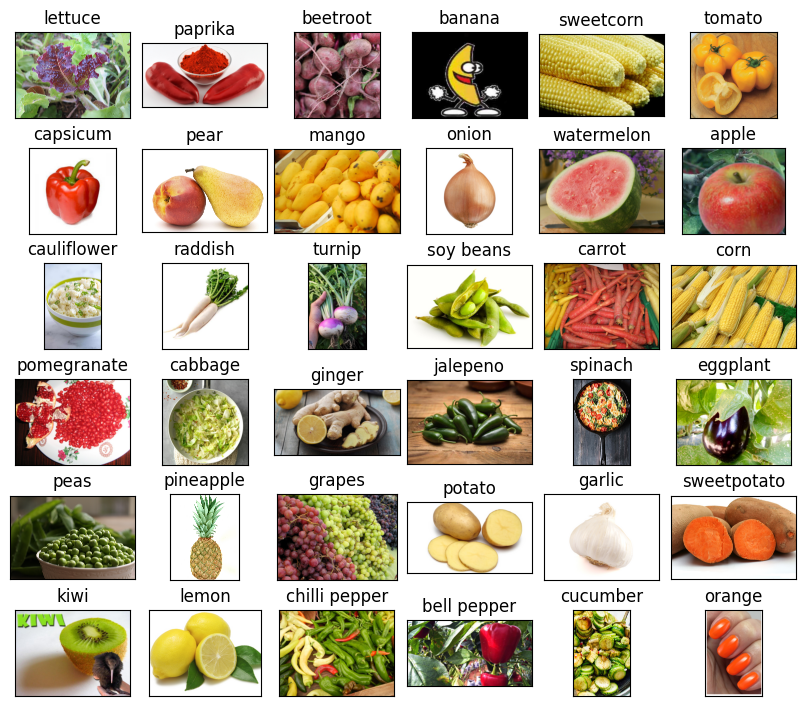

In [ ]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3183 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


100/100 [==============================] - 1079s 11s/step - loss: 1.8057 - accuracy: 0.5275 - val_loss: 0.4159 - val_accuracy: 0.8922
Epoch 2/5
100/100 [==============================] - 266s 3s/step - loss: 0.6885 - accuracy: 0.7961 - val_loss: 0.2415 - val_accuracy: 0.9251
Epoch 3/5
100/100 [==============================] - 249s 2s/step - loss: 0.4313 - accuracy: 0.8671 - val_loss: 0.1887 - val_accuracy: 0.9371
Epoch 4/5
100/100 [==============================] - 250s 2s/step - loss: 0.2747 - accuracy: 0.9133 - val_loss: 0.1372 - val_accuracy: 0.9461
Epoch 5/5
100/100 [==============================] - 251s 3s/step - loss: 0.1759 - accuracy: 0.9444 - val_loss: 0.0915 - val_accuracy: 0.9760


In [ ]:
# Define the file path where you want to save your model
file_path = 'drive/MyDrive/AIR_model.keras'

# Save the model to the file path
model.save(file_path)

NameError: name 'model' is not defined

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

11/11 [==============================] - 26s 2s/step


In [ ]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [ ]:
file_path = '/content/drive/MyDrive/AIR_model.keras'
from tensorflow.keras.models import load_model
# Load the model from the file path
model = load_model(file_path)


In [ ]:
import os
import numpy as np
import time
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Specify the directory
directory = 'drive/MyDrive/AIR_Test'

# Iterate over each entry in the directory
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)  # Get the full path to the file

    # Check if it is a file
    if os.path.isfile(file_path):
        os.remove(file_path)  # Delete the file

print("All files have been deleted.")

# Loop through all files in the folder
image_data=[]
folder_path="/content/drive/MyDrive/AIR_Test/"

def wait_for_files(path):
    while True:
        files = os.listdir(path)
        if files:  # Checks if the list of files is not empty
            print("Files found:", files)
            break  # Exit the loop if files are found
        else:
            print("No files found, checking again in 5 seconds...")
            time.sleep(5)  # Wait for 5 seconds before checking again
wait_for_files(folder_path)
for file in os.listdir(folder_path):

    # Construct the full path to the image
    image_path = os.path.join(folder_path, file)
    print(image_path)
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)/255.0
    image_data.append(img_array)

# Convert the list to a NumPy array
image_data = np.array(image_data)

All files have been deleted.
No files found, checking again in 5 seconds...
No files found, checking again in 5 seconds...
No files found, checking again in 5 seconds...
No files found, checking again in 5 seconds...
No files found, checking again in 5 seconds...
No files found, checking again in 5 seconds...
No files found, checking again in 5 seconds...
No files found, checking again in 5 seconds...
No files found, checking again in 5 seconds...
No files found, checking again in 5 seconds...
No files found, checking again in 5 seconds...
No files found, checking again in 5 seconds...
No files found, checking again in 5 seconds...
No files found, checking again in 5 seconds...
No files found, checking again in 5 seconds...
No files found, checking again in 5 seconds...
No files found, checking again in 5 seconds...
No files found, checking again in 5 seconds...
No files found, checking again in 5 seconds...
No files found, checking again in 5 seconds...
No files found, checking again 

In [ ]:
predictions = model.predict(image_data)
predicted_classes_indices = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 78ms/step


In [ ]:
l=[]
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_classes_indices = [labels[k] for k in predicted_classes_indices]
print(predicted_classes_indices)
for x in predicted_classes_indices:
  print(x)
  l.append(x)

['tomato', 'onion']
tomato
onion


In [ ]:
# Specify the directory
directory = 'drive/MyDrive/AIR_Test'

# Iterate over each entry in the directory
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)  # Get the full path to the file

    # Check if it is a file
    if os.path.isfile(file_path):
        os.remove(file_path)  # Delete the file

print("All files have been deleted.")

All files have been deleted.


In [ ]:
# Open a file for writing
with open('drive/MyDrive/AIR_Test/response.txt', 'w') as file:
    for item in l:
        file.write(item + '\n')